In [ ]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# -------------------------------------
# 🚀 STEP 2: Load Dataset
# ------------------------------------

In [ ]:
# 🔷 Load dataset
df = pd.read_csv("/content/MicrosoftStock.csv")
# 🔷 Clean column names: remove spaces and make lowercase
df.columns = df.columns.str.strip().str.lower()

print(f"✅ Columns found: {list(df.columns)}")

# 🔷 Check for a date column
if 'date' not in df.columns:
    raise KeyError("❌ The dataset does not contain a column named 'Date'. Please check your CSV file.")

# 🔷 Parse dates & set index
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # handle invalid dates as NaT
df.dropna(subset=['date'], inplace=True)  # drop rows where date could not be parsed

df.set_index('date', inplace=True)

# 🔷 Show first 10 rows
print("✅ Dataset loaded successfully. First 10 rows:")
print(df.head(10))

✅ Columns found: ['index', 'date', 'open', 'high', 'low', 'close', 'volume', 'name']
✅ Dataset loaded successfully. First 10 rows:
             index     open   high     low   close    volume  name
date                                                              
2013-02-08  390198  27.3500  27.71  27.310  27.550  33318306  MSFT
2013-02-11  390199  27.6500  27.92  27.500  27.860  32247549  MSFT
2013-02-12  390200  27.8800  28.00  27.750  27.880  35990829  MSFT
2013-02-13  390201  27.9300  28.11  27.880  28.030  41715530  MSFT
2013-02-14  390202  27.9200  28.06  27.870  28.040  32663174  MSFT
2013-02-15  390203  28.0400  28.16  27.875  28.010  49650538  MSFT
2013-02-19  390204  27.8801  28.09  27.800  28.045  38804616  MSFT
2013-02-20  390205  28.1300  28.20  27.830  27.870  44109412  MSFT
2013-02-21  390206  27.7400  27.74  27.230  27.490  49078338  MSFT
2013-02-22  390207  27.6800  27.76  27.480  27.760  31425726  MSFT


In [ ]:
# 📊 Quick Dataset Overview
print(f"✅ Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"📋 Column Names: {df.columns.tolist()}")


✅ Rows: 1259, Columns: 7
📋 Column Names: ['index', 'open', 'high', 'low', 'close', 'volume', 'name']


# -------------------------------------
# 🚀 STEP 3: Preprocessing
# -------------------------------------

In [ ]:
print("\n🔷 Preprocessing & feature engineering...")

df.interpolate(method='linear', inplace=True)

# Technical indicators
df['sma_20'] = df['close'].rolling(20).mean()
df['ema_20'] = df['close'].ewm(span=20).mean()
df['bb_upper'] = df['sma_20'] + 2 * df['close'].rolling(20).std()
df['bb_lower'] = df['sma_20'] - 2 * df['close'].rolling(20).std()

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window).mean()
    loss = -delta.clip(upper=0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['rsi'] = compute_rsi(df['close'])

df.dropna(inplace=True)

# Normalize close price
scaler = MinMaxScaler()
df['close_scaled'] = scaler.fit_transform(df[['close']])

print("✅ Preprocessing complete.")


🔷 Preprocessing & feature engineering...
✅ Preprocessing complete.


/tmp/ipython-input-7-413270000.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


# =====================================
# 🚀 STEP 4: Train-Test Split
# =====================================

In [ ]:
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

features = ['open', 'high', 'low', 'volume', 'sma_20', 'ema_20', 'bb_upper', 'bb_lower', 'rsi']
X_train, y_train = train_df[features], train_df['close']
X_test, y_test = test_df[features], test_df['close']

# =====================================
# 🚀 STEP 5: ML Models
# =====================================

In [ ]:
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}")
    return mae, rmse, r2

print("\n🔷 Training ML models...")

lr = LinearRegression()
lr.fit(X_train, y_train)
evaluate(y_test, lr.predict(X_test), "Linear Regression")

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate(y_test, rf.predict(X_test), "Random Forest")

xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)
evaluate(y_test, xgb.predict(X_test), "XGBoost")


🔷 Training ML models...
Linear Regression: MAE=0.21, RMSE=0.34, R²=1.00
Random Forest: MAE=10.02, RMSE=12.90, R²=-1.46
XGBoost: MAE=10.60, RMSE=13.38, R²=-1.64


(10.596941155464418, np.float64(13.37501007880697), -1.6413501101754435)

# =====================================
# 🚀 STEP 6: LSTM
# =====================================

In [ ]:
print("\n🔷 Training LSTM model...")

def create_sequences(series, seq_len=60):
    X, y = [], []
    for i in range(len(series)-seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

close_scaled = df['close_scaled'].values
train_close = close_scaled[:split_idx]
test_close = close_scaled[split_idx-60:]  # include overlap

X_train_lstm, y_train_lstm = create_sequences(train_close)
X_test_lstm, y_test_lstm = create_sequences(test_close)

X_train_lstm = X_train_lstm.reshape((-1, 60, 1))
X_test_lstm = X_test_lstm.reshape((-1, 60, 1))

lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(60,1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

lstm.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=30, batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stop],
    verbose=1
)

lstm_pred_scaled = lstm.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
y_test_lstm_true = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

evaluate(y_test_lstm_true, lstm_pred, "LSTM")


🔷 Training LSTM model...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0234 - val_loss: 0.0124
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0019 - val_loss: 8.8879e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0011 - val_loss: 6.8832e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0010 - val_loss: 5.0688e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0010 - val_loss: 9.5213e-04
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 9.8263e-04 - val_loss: 0.0010
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 9.9193e-04 - val_loss: 0.0014
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
LSTM: MAE=1.

(1.1514603005686102, np.float64(1.511587309748823), 0.9662631749390906)

# =====================================
# 🚀 STEP 7: Visualize Results and predit for 30 days and  save the model
# =====================================

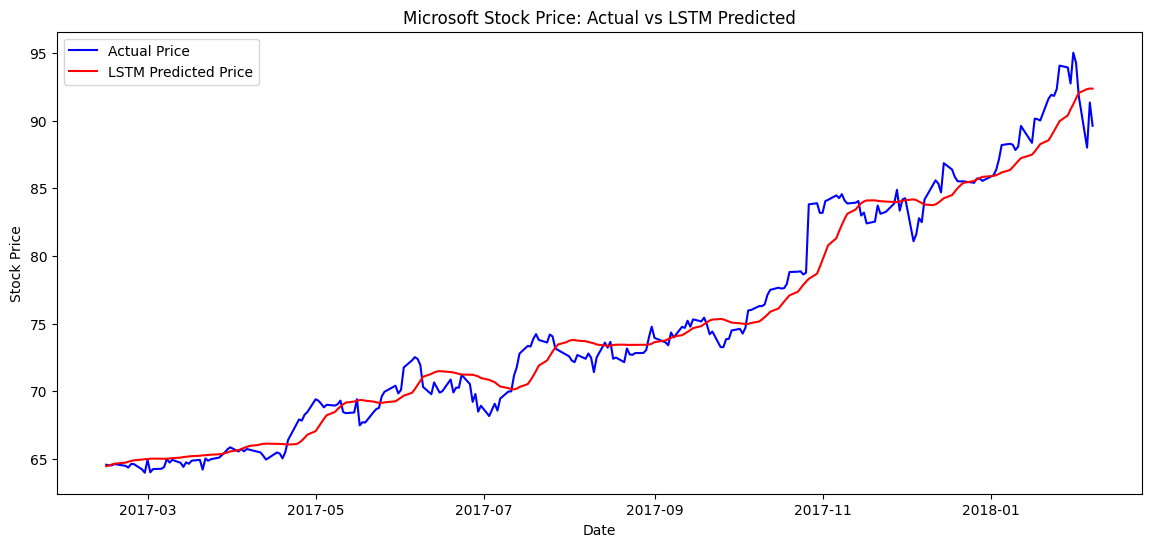


🔷 Forecasting next 30 days...


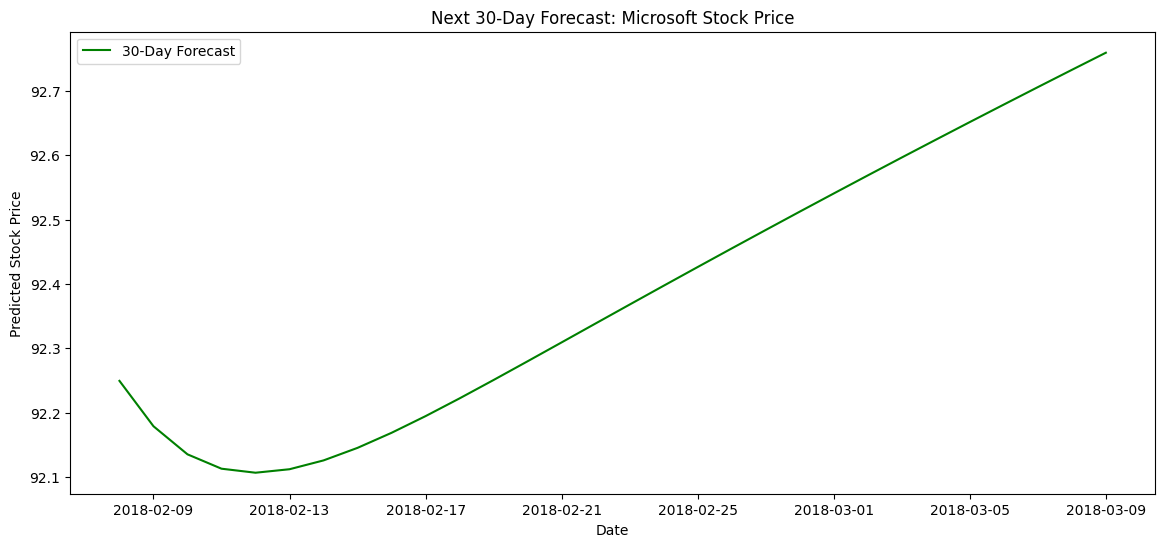

✅ 30-Day Forecast:
            Predicted Price
2018-02-08        92.249214
2018-02-09        92.178680
2018-02-10        92.135040
2018-02-11        92.112709
2018-02-12        92.106468
2018-02-13        92.111893
2018-02-14        92.125610
2018-02-15        92.145119
2018-02-16        92.168518
2018-02-17        92.194443
2018-02-18        92.222031
2018-02-19        92.250595
2018-02-20        92.279686
2018-02-21        92.309029
2018-02-22        92.338470
2018-02-23        92.367828
2018-02-24        92.397072
2018-02-25        92.426147
2018-02-26        92.455025
2018-02-27        92.483696
2018-02-28        92.512192
2018-03-01        92.540436
2018-03-02        92.568497
2018-03-03        92.596344
2018-03-04        92.623962
2018-03-05        92.651413
2018-03-06        92.678635
2018-03-07        92.705704
2018-03-08        92.732544
2018-03-09        92.759201

✅ Project completed successfully. LSTM model saved as 'lstm_microsoft_model.h5'


In [ ]:
# 🚀 STEP: Plot Actual vs LSTM Predicted


plt.figure(figsize=(14,6))
plt.plot(test_df.index[-len(y_test_lstm_true):], y_test_lstm_true, label="Actual Price", color='blue')
plt.plot(test_df.index[-len(y_test_lstm_true):], lstm_pred, label="LSTM Predicted Price", color='red')
plt.title("Microsoft Stock Price: Actual vs LSTM Predicted")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# 🚀 STEP: Forecast Next 30 Days

print("\n🔷 Forecasting next 30 days...")

# Take the last 60 timesteps from the entire data to start forecast
last_60 = df['close_scaled'].values[-60:]

future_predictions_scaled = []

for _ in range(30):
    # reshape to model input shape
    seq_input = last_60[-60:].reshape((1, 60, 1))
    pred_scaled = lstm.predict(seq_input, verbose=0)[0,0]
    future_predictions_scaled.append(pred_scaled)
    # append this prediction to the sequence
    last_60 = np.append(last_60, pred_scaled)

# Inverse scale to get actual prices
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1,1))

# Create date range for next 30 days
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Create a DataFrame for forecast
forecast_df = pd.DataFrame({
    'Predicted Price': future_predictions.flatten()
}, index=future_dates)

# Plot forecast
plt.figure(figsize=(14,6))
plt.plot(forecast_df.index, forecast_df['Predicted Price'], label="30-Day Forecast", color='green')
plt.title("Next 30-Day Forecast: Microsoft Stock Price")
plt.xlabel("Date")
plt.ylabel("Predicted Stock Price")
plt.legend()
plt.show()

# Print forecast table
print("✅ 30-Day Forecast:")
print(forecast_df)

# 🚀 STEP: Save the Trained LSTM Model

lstm.save("lstm_microsoft_model.h5")
print("\n✅ Project completed successfully. LSTM model saved as 'lstm_microsoft_model.h5'")
